In [35]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

In [2]:
## load the data

full_df = pd.read_pickle("2010_data.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME', 'geometry'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,4.351195e-06,4.876012e-09,3.973694e-06,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,2.916594e-06,25.766945,25.620820,2.109251e-06,4.289945e-06,3.297524e-06,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,1.011381e-06,0.000008,1.620365e-06
1,77.826608,286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,3.513297e-06,4.926652e-09,2.062545e-06,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,2.408668e-06,27.838995,27.701486,2.641386e-06,5.453165e-06,4.363785e-06,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,2.088636e-06,0.000008,1.140217e-06
2,75.841973,284.124711,291.030084,0.006434,0.01800,0.010576,4.154440,2.339233,101690.626048,0.073790,1.528844e-08,2.094088e-08,0.007874,0.879026,245.431868,0.006236,0.067283,100229.513473,272.708199,0.165957,0.000885,0.000003,4.161191e-06,4.878442e-09,3.484876e-06,0.009897,0.000005,0.000003,4.412445e-07,0.006521,0.000009,6.841318e-07,2.561723e-06,26.076443,25.936913,2.072566e-06,4.220296e-06,3.329836e-06,1.460098e-07,0.000002,5.375428e-07,0.000013,2.383421e-07,0.000016,1.124706e-06,0.000008,1.212712e-06
3,73.705432,283.448675,290.734945,0.006233,0.01800,0.010422,3.859579,2.695780,101696.274163,0.077023,1.467121e-08,2.014099e-08,0.007201,0.878604,274.363643,0.005314,0.073008,100215.778699,272.652578,0.173887,0.000894,0.000003,4.369584e-06,4.879895e-09,3.844808e-06,0.009893,0.000005,0.000004,5.053737e-07,0.006622,0.000009,7.044878e-07,3.263775e-06,25.607194,25.458810,2.049331e-06,4.173433e-06,3.204589e-06,1.257123e-07,0.000003,5.365352e-07,0.000013,2.220161e-07,0.000015,9.132320e-07,0.000008,1.971961e-06
4,75.753407,282.868247,289.766565,0.006107,0.01800,0.008332,3.234586,2.781183,101710.006570,0.077158,1.519334e-08,2.097774e-08,0.006178,0.877193,276.665988,0.006156,0.074710,99027.783845,272.614234,0.172485,0.000889,0.000003,4.043741e-06,4.893173e-09,2.631260e-06,0.009770,0.000005,0.000004,5.254242e-07,0.006689,0.000009,7.188703e-07,3.696579e-06,24.042930,23.889293,1.644247e-06,3.319324e-06,2.564080e-06,1.292652e-07,0.000003,5.195765e-07,0.000013,1.988160e-07,0.000013,7.093172e-07,0.000008,2.447597e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.842111,278.301219,0.004760,0.01800,0.004101,2.370862,0.499930,101630.449624,0.043633,7.253336e-09,1.103061e-08,0.005092,0.798388,288.873684,0.016426,0.023886,78530.596578,268.911264,0.081471,0.000644,0.000003,1.057299e-06,4.941603e-09,8.047194e-08,0.007655,0.000003,0.000002,4.937694e-07,0.006915,0.000005,5.093373e-07,1.734801e-06,7.928388,7.855770,5.407217e-07,1.250976e-06,3.762784e-06,9.304454e-08,0.000002,4.126463e-07,0.000008,2.043045e-07,0.000013,9.202822e-07,0.000003,1.312529e-06
3123,83.771012,267.887551,274.410086,0.004909,0.01800,0.001664,2.481296,2.428177,101634.772736,0.046080,6.861324e-09,9.790676e-09,0.006100,0.807739,305.402204,0.095034,0.021758,75497.845779,268.751272,0.080511,0.000615,0.000003,8.352510e-07,4.851321e-09,7.964809e-08,0.007339,0.000003,0.000001,2.701267e-07,0.007030,0.000004,4.969263e-07,5.508047e-07,6.659885,6.563536,2.826886e-07,6.105456e

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.53


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()


In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')


RMSE scores for each fold: [1.60294055 1.44785844 1.39776458 1.35291408]
Mean RMSE score: 1.4503694097479283
Standard deviation of RMSE scores: 0.09427230094076218


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'n_estimators':[80,90,100,110,120,150], 'max_features': [6,8,10,12,15], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 270 candidates, totalling 1080 fits
CPU times: total: 36min 30s
Wall time: 6min 2s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [6, 8, 10, 12, 15],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [80, 90, 100, 110, 120, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=200, max_features=10, min_samples_split=5,
                      n_estimators=120, n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.66


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.63


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.39


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.93


In [14]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.64


In [15]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.92
The adjusted test r_sq ::: 0.61


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

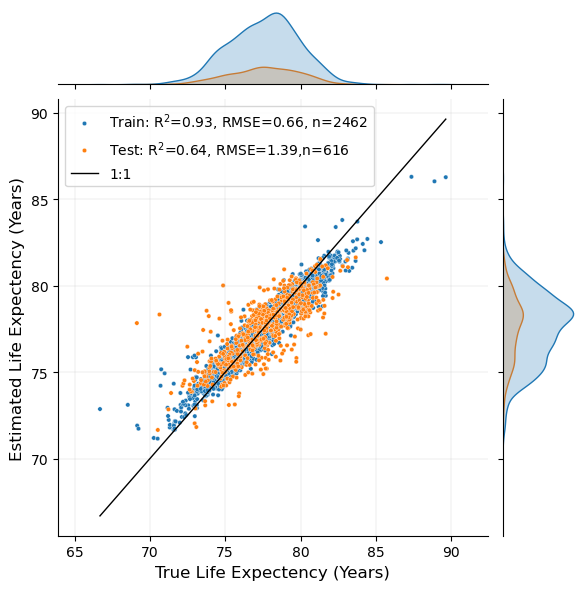

In [17]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  


g.ax_joint.legend(handles=handles,  labels=[ f'Train: R$^2$={corr_train}, RMSE={rmse_train}, n={len(X_train)}', 
                                             f'Test: R$^2$={corr_test}, RMSE={rmse_test},n={len(X_test)}','1:1'],
                                                                                                        title=None)

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

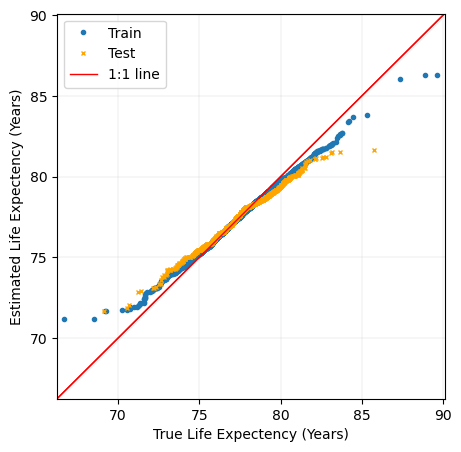

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

## Find feature importance on the train set

In [19]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
train_permutation

{'importances_mean': array([ 6.04909435e-02,  6.44298685e-02,  2.80715989e-02,  8.25658139e-03,
         8.18041512e-02,  3.80120486e-02,  5.58753940e-02,  1.23819189e-01,
         3.63100118e-02, -7.40148683e-17, -9.86864911e-17,  3.02060398e-02,
         3.98849537e-02,  3.89936585e-02,  2.56738641e-02,  8.03122823e-02,
         3.19762088e-02,  4.35224368e-02,  4.13401942e-02,  3.60628252e-02,
         1.76567068e-04,  1.76257470e-03, -8.63506797e-17,  8.64004943e-03,
         3.23188752e-02,  3.39841055e-03,  7.93251943e-03,  3.39500917e-04,
         4.91912836e-02,  3.39975634e-03,  2.38861943e-05,  4.45736626e-03,
         6.26717916e-02,  7.50423853e-02,  7.44201323e-04,  3.77434336e-03,
         6.66379064e-03,  3.91909465e-06,  1.65483265e-03,  3.82285436e-06,
         9.13622727e-03,  5.55978154e-05,  1.20870220e-02,  2.93359786e-03,
         6.13522931e-03,  4.14217667e-03]),
 'importances_std': array([1.22207743e-03, 1.33685705e-03, 5.41780997e-04, 2.56737816e-04,
        2

In [20]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [21]:
mean_val

array([ 6.04909435e-02,  6.44298685e-02,  2.80715989e-02,  8.25658139e-03,
        8.18041512e-02,  3.80120486e-02,  5.58753940e-02,  1.23819189e-01,
        3.63100118e-02, -7.40148683e-17, -9.86864911e-17,  3.02060398e-02,
        3.98849537e-02,  3.89936585e-02,  2.56738641e-02,  8.03122823e-02,
        3.19762088e-02,  4.35224368e-02,  4.13401942e-02,  3.60628252e-02,
        1.76567068e-04,  1.76257470e-03, -8.63506797e-17,  8.64004943e-03,
        3.23188752e-02,  3.39841055e-03,  7.93251943e-03,  3.39500917e-04,
        4.91912836e-02,  3.39975634e-03,  2.38861943e-05,  4.45736626e-03,
        6.26717916e-02,  7.50423853e-02,  7.44201323e-04,  3.77434336e-03,
        6.66379064e-03,  3.91909465e-06,  1.65483265e-03,  3.82285436e-06,
        9.13622727e-03,  5.55978154e-05,  1.20870220e-02,  2.93359786e-03,
        6.13522931e-03,  4.14217667e-03])

In [22]:
mean_importance

[(0.12381918912886958, 'msl'),
 (0.081804151233492, 'duaod550'),
 (0.0803122822946164, 'suaod550'),
 (0.07504238526633182, 'tcwv'),
 (0.0644298685075973, 't2m'),
 (0.062671791635253, 'tcw'),
 (0.06049094349507035, 'd2m'),
 (0.055875394013612224, 'lai_lv'),
 (0.0491912836362555, 'gtco3'),
 (0.04352243680129015, 'tsn'),
 (0.041340194211750475, 'aod550'),
 (0.039884953656095554, 'asn'),
 (0.03899365847753016, 'rsn'),
 (0.0380120486182368, 'lai_hv'),
 (0.036310011849768155, 'omaod550'),
 (0.036062825159291406, 'tcco'),
 (0.03231887519957609, 'tc_ch4'),
 (0.03197620875938899, 'sp'),
 (0.03020603984501307, 'ssaod550'),
 (0.02807159889375556, 'bcaod550'),
 (0.02567386405399287, 'sd'),
 (0.012087022025307216, 'aermssssm'),
 (0.009136227270103424, 'aermssomhphob'),
 (0.008640049425868613, 'tc_c5h8'),
 (0.008256581386599966, 'chnk'),
 (0.007932519432604127, 'tcno2'),
 (0.006663790637277277, 'aermssdul'),
 (0.006135229310114454, 'aermsssu'),
 (0.004457366261172213, 'tcso2'),
 (0.00414217667022196

In [23]:
std_importance

[(0.0030290466239247023, 'msl'),
 (0.002994110244147204, 'suaod550'),
 (0.0020141620822503635, 'duaod550'),
 (0.0019074078499431934, 'tcw'),
 (0.0015352838394720944, 'tcwv'),
 (0.0014413296731123578, 'lai_lv'),
 (0.0014227684577932964, 'lai_hv'),
 (0.0014173092679684322, 'gtco3'),
 (0.0013748757000157346, 'tcco'),
 (0.0013368570524552987, 't2m'),
 (0.0012220774313857212, 'd2m'),
 (0.0011917813189987589, 'aod550'),
 (0.0011079117637213599, 'tsn'),
 (0.0010760315419465452, 'rsn'),
 (0.001002497041517959, 'tc_ch4'),
 (0.0007468116043058767, 'sp'),
 (0.0006925229028310286, 'asn'),
 (0.0006359912560827619, 'omaod550'),
 (0.0005417809972742005, 'bcaod550'),
 (0.000527337644134304, 'aermssssm'),
 (0.00041793660657434126, 'sd'),
 (0.0003771476321939142, 'aermssomhphob'),
 (0.00037030331079345065, 'aermssdul'),
 (0.00037002727568696304, 'ssaod550'),
 (0.0002954168582355053, 'tc_c5h8'),
 (0.0002567378161805197, 'chnk'),
 (0.00025278701551575316, 'aermssdum'),
 (0.00023354846159370836, 'tc_hno3')

In [24]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

          Feature   Mean Weight  Standard Deviation
7             msl  1.238192e-01        3.029047e-03
4        duaod550  8.180415e-02        2.014162e-03
15       suaod550  8.031228e-02        2.994110e-03
33           tcwv  7.504239e-02        1.535284e-03
1             t2m  6.442987e-02        1.336857e-03
32            tcw  6.267179e-02        1.907408e-03
0             d2m  6.049094e-02        1.222077e-03
6          lai_lv  5.587539e-02        1.441330e-03
28          gtco3  4.919128e-02        1.417309e-03
17            tsn  4.352244e-02        1.107912e-03
18         aod550  4.134019e-02        1.191781e-03
12            asn  3.988495e-02        6.925229e-04
13            rsn  3.899366e-02        1.076032e-03
5          lai_hv  3.801205e-02        1.422768e-03
8        omaod550  3.631001e-02        6.359913e-04
19           tcco  3.606283e-02        1.374876e-03
24         tc_ch4  3.231888e-02        1.002497e-03
16             sp  3.197621e-02        7.468116e-04
11       ssa

<Axes: xlabel='Mean Weight', ylabel='Feature'>

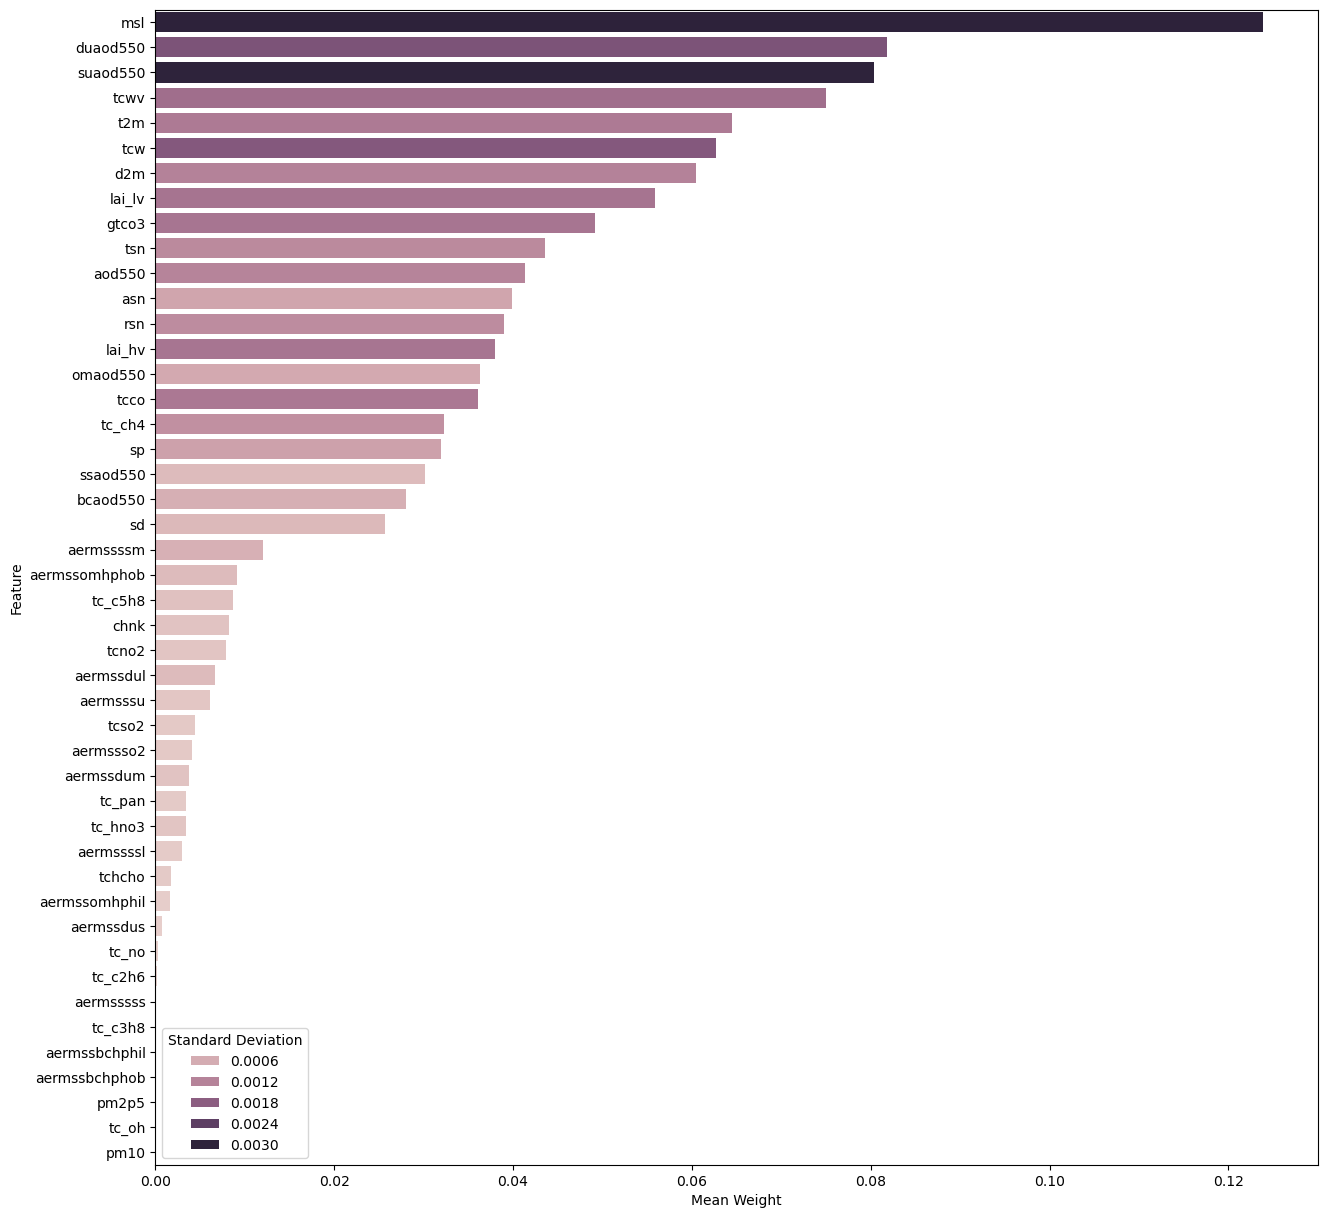

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find permutation importance in test set

In [26]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5


<Axes: xlabel='Mean Weight', ylabel='Feature'>

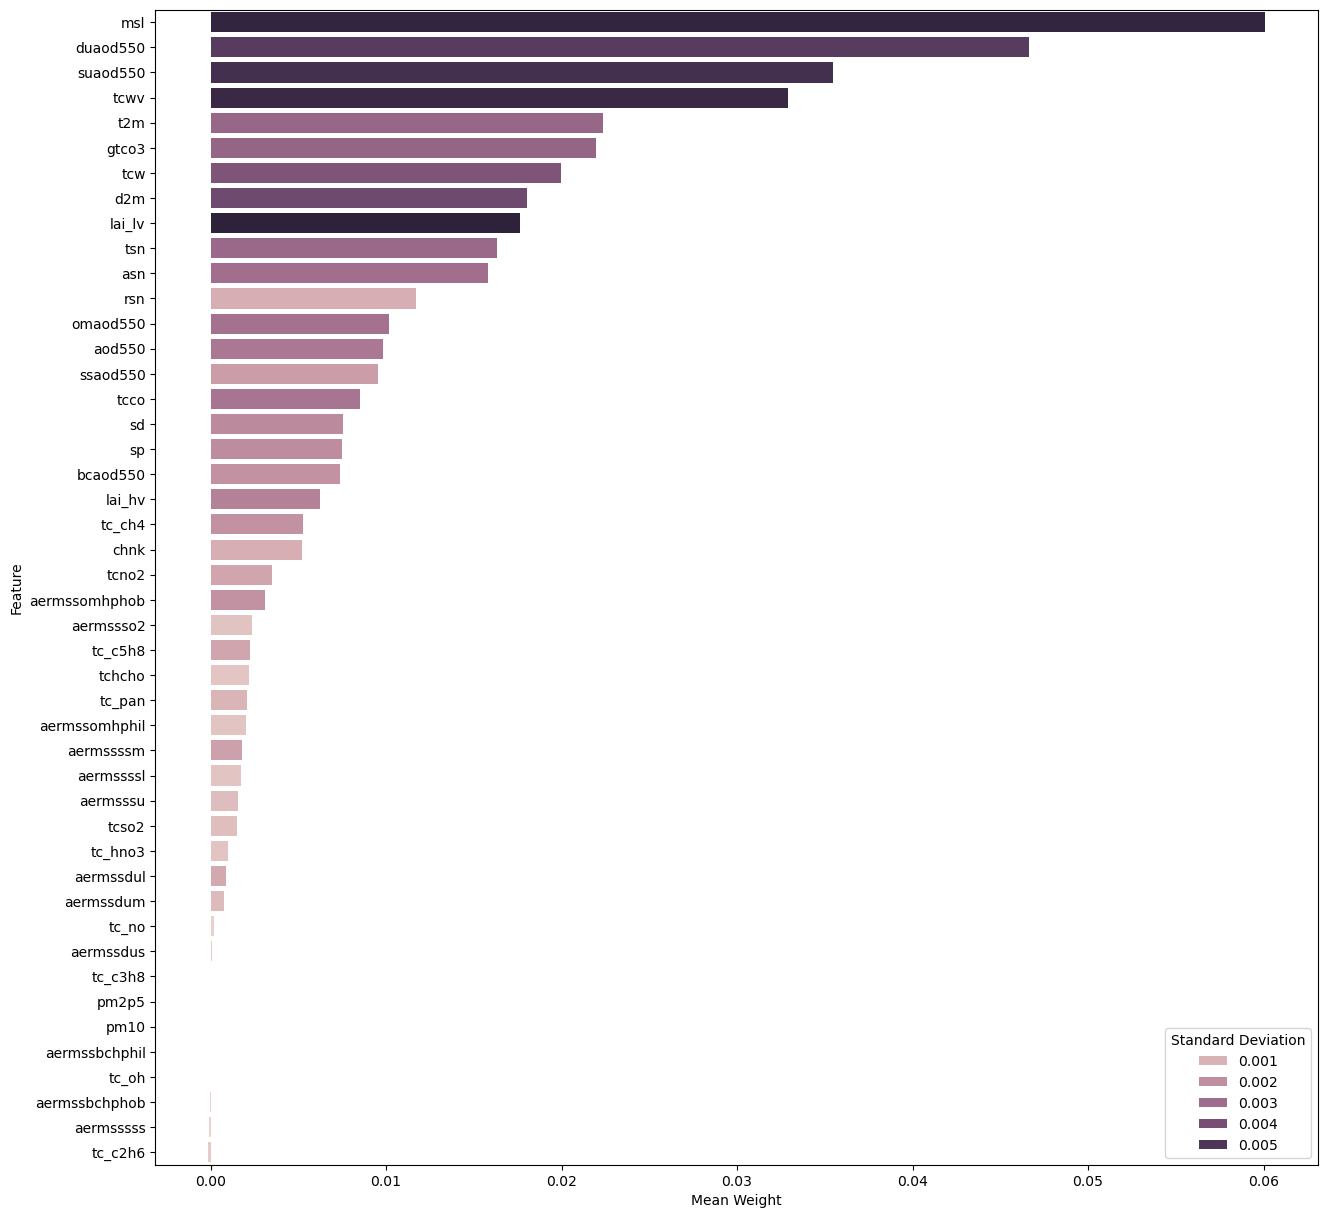

In [27]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

## Find feature importance using SHAP
### This step is necessary because of the Warning sign here https://scikit-learn.org/1.5/modules/permutation_importance.html

In [28]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)


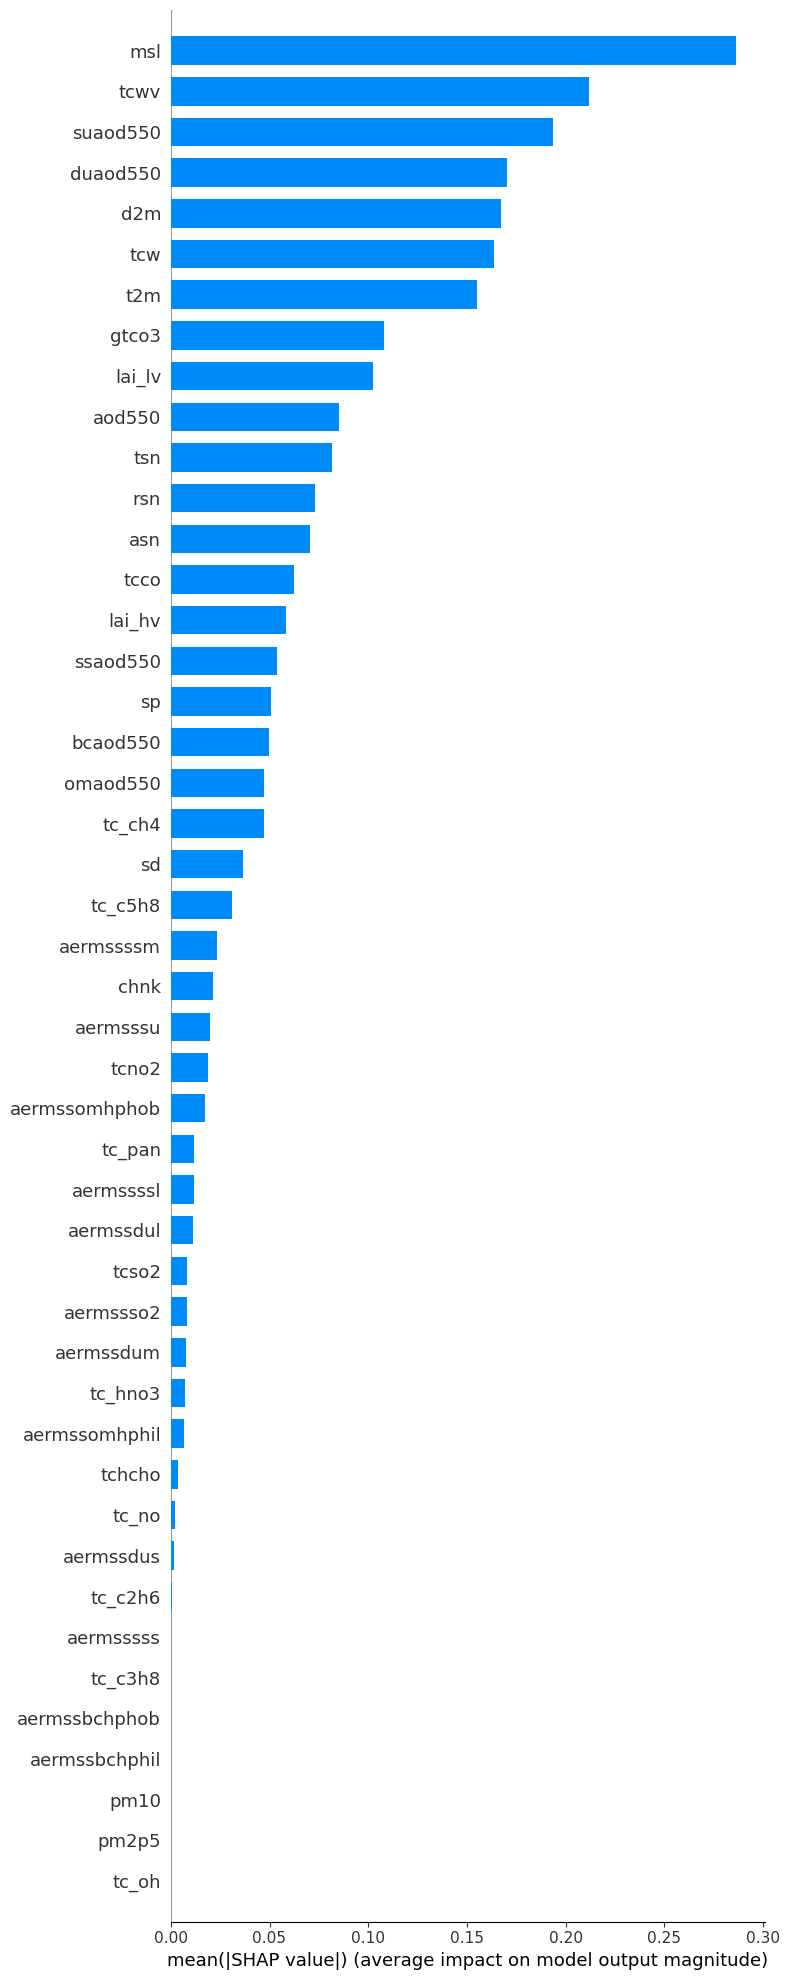

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

In [30]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

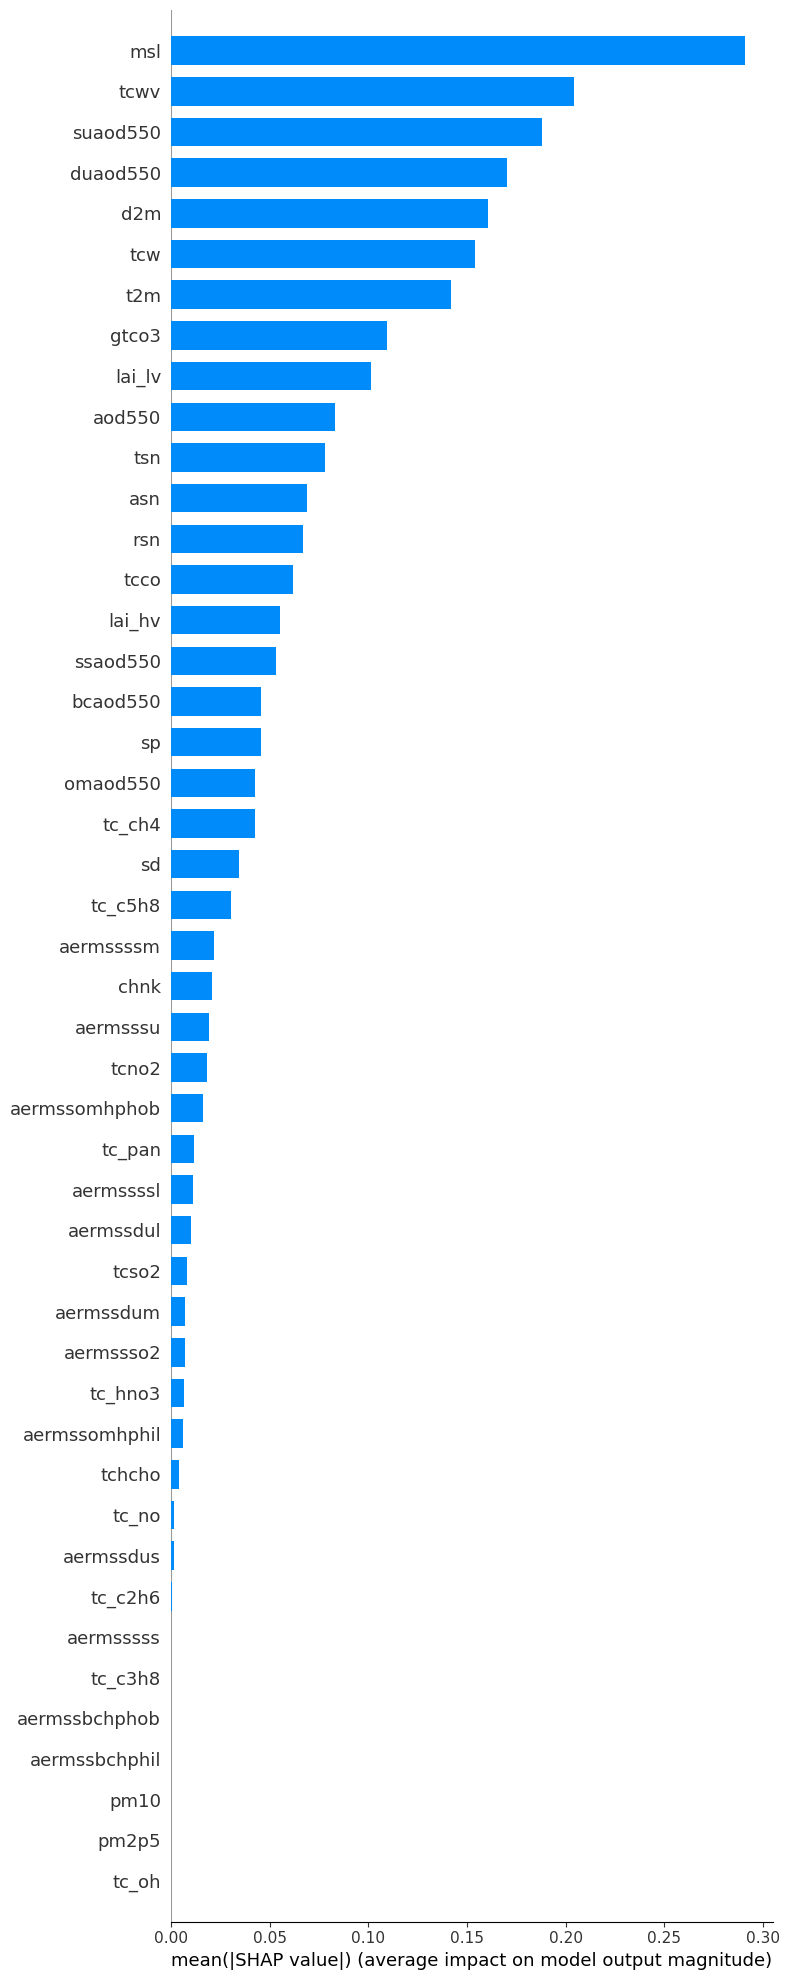

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

# Plot Actual and Estimated Values on a map

In [43]:
##  load the county shapefile

SHAPE_PATH = os.path.join("County_shapefile",'gz_2010_us_050_00_500k.shp')
county_gdf = gpd.read_file(SHAPE_PATH)

county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [45]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum
## This step is necessary because there can be several counties with idential names. 

county_gdf['fips']=county_gdf['STATE'] + county_gdf['COUNTY']
county_gdf.dtypes
## convert the data type
county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041


In [53]:
full_df = pd.read_pickle("2010_data.pkl")
full_df.head(2)

,location_name,fips,year,MeanLifeExpectency,NAME,geometry,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",283.454410,291.089093,0.006284,0.01800,0.010721,3.928873,2.633910,101693.509736,0.075966,1.445389e-08,1.981001e-08,0.007574,0.878745,271.096109,0.005542,0.071412,100187.304165,272.665101,0.171956,0.000890,0.000003,0.000004,4.876012e-09,0.000004,0.009891,0.000005,0.000003,4.658415e-07,0.006583,0.000009,6.953380e-07,0.000003,25.766945,25.620820,0.000002,0.000004,0.000003,1.285140e-07,0.000003,5.390907e-07,0.000013,2.305156e-07,0.000016,0.000001,0.000008,0.000002
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",286.767193,292.241782,0.006410,0.01527,0.013597,3.930011,2.508253,101685.471788,0.072641,1.346257e-08,1.847324e-08,0.010417,0.879538,193.698250,0.004818,0.069880,101309.280631,275.408300,0.172946,0.000875,0.000003,0.000004,4.926652e-09,0.000002,0.010006,0.000005,0.000003,4.380713e-07,0.006433,0.000008,6.623504e-07,0.000002,27.838995,27.701486,0.000003,0.000005,0.000004,1.200844e-07,0.000002,5.609629e-07,0.000013,2.891494e-07,0.000021,0.000002,0.000008,0.000001


In [55]:
true_LE = full_df[['fips', 'MeanLifeExpectency']]
type(true_LE)

pandas.core.frame.DataFrame

In [62]:
true_LE

,fips,MeanLifeExpectency
0,1001,75.728489
1,1003,77.826608
2,1005,75.841973
3,1007,73.705432
4,1009,75.753407
...,...,...
3122,56037,77.582422
3123,56039,83.771012
3124,56041,77.836526
3125,56043,78.674180


In [63]:
gpd_df = pd.merge(county_gdf, true_LE, on='fips', how='left') 
gpd_df= gpd_df.dropna()
gpd_df.head(2)
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374


In [106]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [107]:
state_shape

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [112]:
## include only CONUS shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


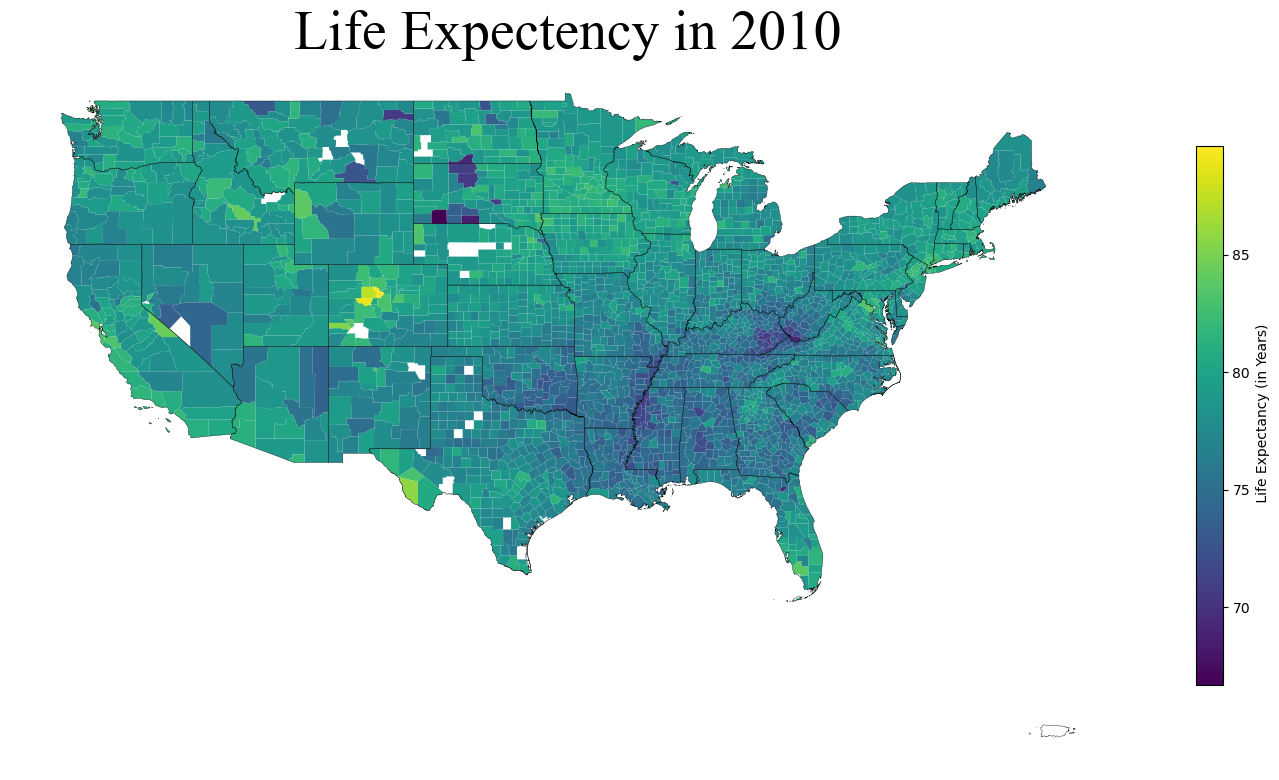

In [128]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50})
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()